In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.viz import plot2d

from symlie.model.networks.linear import CalculatedP, LinearP
from symlie.model.networks.implicit import LinearImplicit
from symlie.misc.utils_results import pivot, assert_columns_same, get_and_check_Ps, stringify_dict, aggregate_dataset, plot_best, return_table, plot_pivot
from symlie.misc.wandb import update_results_df, get_inspect_df, get_inspectdev_df
from symlie.model.setup import load_P_pred
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow

from symlie.run import parse_options, main, process_args


In [9]:
# args = parse_options(notebook=True)

# args.seed = 42
# args.net = 'TrainP'

# args.data_dir = '../data/noise'
# args.grid_size = (1,7)
# args.noise_std = 1.
# args.eps_mult = [0., 0., 1., 0.]

# args.run_id = 'mtcvyata'
# args.do_return = True
# args.train = False

# process_args(args)
# model, trainer, datamodule = main(args)
# model.eval();

args = parse_options(notebook=True)

args.seed = 42
args.net = 'TrainImplicitP'
args.hidden_implicit_layers = [49, 49]

args.data_dir = '../data/noise'
args.grid_size = (1,7)
args.noise_std = 1.
args.eps_mult = [0., 0., 1., 0.]

# args.run_id = 'temp_runid'

args.logger = None

args.do_return = True
args.train = True

process_args(args)
model, trainer, datamodule = main(args)
model.eval();


Seed set to 42


Setup implicit_P
../logs/symlie/temp_runid/checkpoints


FileNotFoundError: [Errno 2] No such file or directory: '../logs/symlie/temp_runid/checkpoints'

In [8]:
trainer.num_training_batches, trainer.num_val_batches

(inf, [])

In [3]:
# P = load_P_pred('4zhsjs98')
# imshow(P, l = 0.5)

In [4]:
size = np.prod(args.grid_size)
set_bias = args.bias
batch_size = args.batch_size

In [5]:
x, _, _ = batch = next(iter(datamodule.test_dataloader()))

In [6]:
def transform(x):
    return torch.roll(x, 1, 1)

In [7]:
# linear_p = LinearP(in_features=size, out_features=size, bias = set_bias, P_init = P)

# assert size == 7
# linear_implicit = LinearImplicit(
#     in_features = 7, 
#     out_features = 7,
#     bias = False,
#     hidden_implicit_layers = [49, 49],
# )
# implicit_statedict = torch.load('../logs/store/implicit_P/mtcvyata.pt')
# linear_implicit.implicit_P.load_state_dict(implicit_statedict)

# linear = linear_p
# linear = linear_implicit
linear = model.net
linear.reset_parameters()

linear.eval()

LinearImplicit(
  (implicit_P): Sequential(
    (0): Linear(in_features=49, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=49, bias=True)
    (3): ReLU()
    (4): Linear(in_features=49, out_features=49, bias=True)
    (5): ReLU()
  )
)

In [8]:
x_a = x
out_a = linear(x_a).detach()
out_a_prime = transform(out_a)

x_b = x
x_b_prime = transform(x_b)
out_b_prime = linear(x_b_prime).detach()

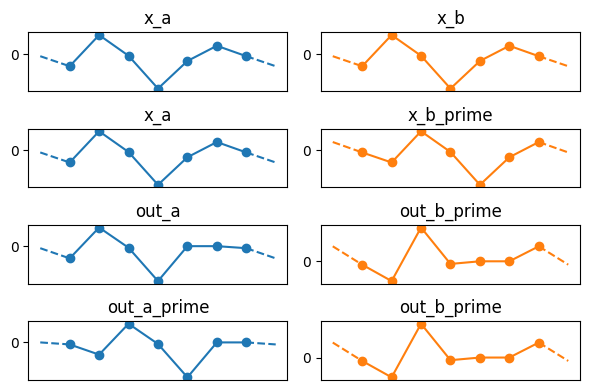

In [9]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

x_plots = [
    [x_a, x_b],
    [x_a, x_b_prime],
    [out_a, out_b_prime],
    [out_a_prime, out_b_prime],
]

x_titles = [
    ['x_a', 'x_b'],
    ['x_a', 'x_b_prime'],
    ['out_a', 'out_b_prime'],
    ['out_a_prime', 'out_b_prime'],
    ['out_a_prime_tilde', 'out_b_prime_tilde']
]
plot_2columns(x_plots, x_titles)

In [114]:
def network_simple_plot(x, savename, subdir, color, l = 1.):
    x = x[0]
    fig, ax = plt.subplots(1, 1, figsize = np.array([3, 1])*l, tight_layout = True)
    ax.plot(x, color = color, marker = 'o')
    ax.axis('off')
    # plt.show()
    # return
    savefig(fig, savename, subdir = subdir)
    plt.close()

print(args.run_id)
save_plots = [(x, 'x'), (x_b_prime, 'x_b_prime'), (out_a, 'o_a'), (out_a_prime, 'o_a_prime'), (out_b_prime, 'o_b_prime')]
for save_fig, save_name in save_plots:
    if 'x' in save_name:
        color = 'tab:blue'
    elif 'o' in save_name:
        color = 'tab:red'
    else:
        raise ValueError

    
    network_simple_plot(save_fig, save_name, subdir = os.path.join('stepa', args.run_id), color = color)

gt4l7m0f


In [112]:
weight = linear.weight.data
implicitP = linear.implicit_P
print(weight.mean(), weight.std())

weight2 = implicitP(weight.flatten()).reshape(weight.shape)
# weight2 = linear.normalize_weight(weight2)
print(weight2.mean(), weight2.std())

weight2

tensor(0.0569) tensor(0.9937)
tensor(0.0714, grad_fn=<MeanBackward0>) tensor(0.1767, grad_fn=<StdBackward0>)


tensor([[0.4980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4993, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4986, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5001, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5014]],
       grad_fn=<ViewBackward0>)

In [51]:
eps = torch.randn((4,))
eps_multed = eps * model.eps_mult
eps_multed = eps_multed.repeat(batch_size, 1).to(x_a.device)

phi_x_a = model.generator(torch.cat([x_a, eps_multed], dim=1)).detach()
phi_out_a = model.generator(torch.cat([out_a, eps_multed], dim=1)).detach()
(phi_x_a - x_b_prime) - (phi_out_a - out_b_prime);

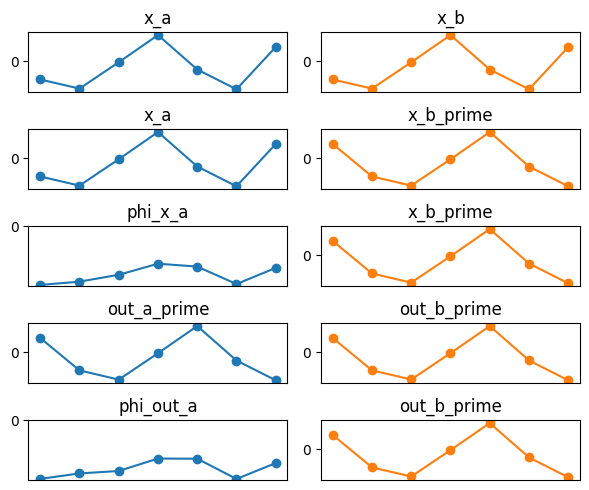

In [52]:
x_plots = [
    [x_a, x_b],
    [x_a, x_b_prime],
    [phi_x_a, x_b_prime],
    [out_a_prime, out_b_prime],
    [phi_out_a, out_b_prime],
]

x_titles = [
    ['x_a', 'x_b'],
    ['x_a', 'x_b_prime'],
    ['phi_x_a', 'x_b_prime'],
    ['out_a_prime', 'out_b_prime'],
    ['phi_out_a', 'out_b_prime']
]
plot_2columns(x_plots, x_titles)

weight torch.Size([7, 7])


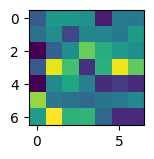

implicit_P.0.weight torch.Size([49, 49])


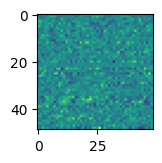

implicit_P.0.bias torch.Size([49])


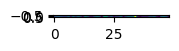

implicit_P.2.weight torch.Size([49, 49])


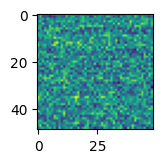

implicit_P.2.bias torch.Size([49])


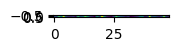

implicit_P.4.weight torch.Size([49, 49])


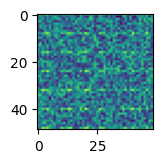

implicit_P.4.bias torch.Size([49])


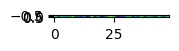

In [29]:
for name, param in linear.named_parameters():
    print(name, param.shape)
    if len(param.shape) == 1: 
        param = param.unsqueeze(0)
    imshow(param.detach(), l = 1/len(param.shape))